In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = "../../data/schedule_processed/"

In [3]:
full_activities = pd.read_csv(f"{data_path}/24h_full_activities_homebound_wd.csv")

In [4]:
len(full_activities["persid"].unique())

42817

In [5]:
full_seq_gb = full_activities.groupby("persid")["purpose"].apply(lambda x: list(x))
full_seq_gb = full_seq_gb.apply(str)
full_counts = full_seq_gb.value_counts()

In [6]:
small_sz = 0.05
small_percent = pd.read_csv(f"{data_path}/24h_{small_sz:.2f}_activities_homebound_wd.csv")
small_seq_gb = small_percent.groupby("persid")["purpose"].apply(lambda x: list(x))
small_seq_gb = small_seq_gb.apply(str)

In [7]:
store_analysis = {"sample_rate": [0, small_sz], "sampled_unique_sequences": [0.0], "sampled_sequence_coverage": [0.0]}

In [8]:
small_seq_counts = small_seq_gb.value_counts()
small_unique_rate = len(small_seq_counts) / len(full_counts)
store_analysis["sampled_unique_sequences"].append(small_unique_rate)

small_coverage = full_counts[small_seq_counts.index].sum() / full_counts.sum()
store_analysis["sampled_sequence_coverage"].append(small_coverage)


In [9]:
for sample_rate in np.arange(0.1, 1.0, 0.1):
    store_analysis["sample_rate"].append(sample_rate)
    sample_activities = pd.read_csv(f"{data_path}/24h_{sample_rate:.1f}_activities_homebound_wd.csv")
    sample_seq_gb = sample_activities.groupby("persid")["purpose"].apply(lambda x: list(x))
    sample_seq_gb = sample_seq_gb.apply(str)
    sample_seq_counts = sample_seq_gb.value_counts()
    sample_unique_rate = len(sample_seq_counts) / len(full_counts)
    store_analysis["sampled_unique_sequences"].append(sample_unique_rate)
    sample_coverage = full_counts[sample_seq_counts.index].sum() / full_counts.sum()
    store_analysis["sampled_sequence_coverage"].append(sample_coverage)


In [10]:
store_analysis["sample_rate"].append(1)
store_analysis["sampled_unique_sequences"].append(1.0)
store_analysis["sampled_sequence_coverage"].append(1.0)

In [11]:
check_analysis = pd.DataFrame(store_analysis)

In [12]:
check_analysis

,sample_rate,sampled_unique_sequences,sampled_sequence_coverage
0,0.00,0.000000,0.000000
1,0.05,0.131390,0.884672
2,0.10,0.216206,0.917626
3,0.20,0.343052,0.941892
4,0.30,0.458160,0.957353
5,0.40,0.560394,0.967186
6,0.50,0.652783,0.975477
7,0.60,0.728133,0.981573
8,0.70,0.798940,0.987085
9,0.80,0.862931,0.991335


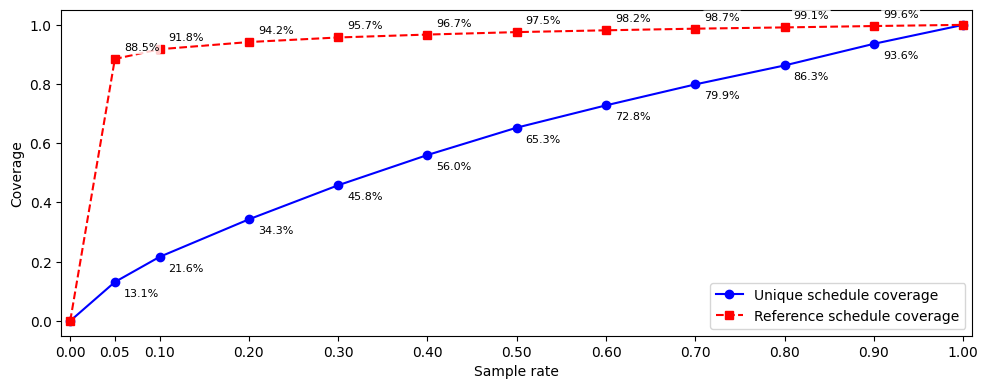

In [15]:
import matplotlib.pyplot as plt

x  = check_analysis["sample_rate"].to_numpy()
y1 = check_analysis["sampled_unique_sequences"].to_numpy()
y2 = check_analysis["sampled_sequence_coverage"].to_numpy()

# wider figure
fig, ax = plt.subplots(figsize=(10, 4))   # increase 10 → 12 if you want even longer

# Plot lines (black, different markers/styles)
ax.plot(x, y1, color="blue", marker="o", linestyle="-", label="Unique schedule coverage")
ax.plot(x, y2, color="red", marker="s", linestyle="--", label="Reference schedule coverage")

# force all sample_rate values as x-ticks
ax.set_xticks(x)
ax.set_xlim(x.min() - 0.01, x.max() + 0.01)

ymin, ymax = ax.get_ylim()
y_off = 0.02 * (ymax - ymin)
x_off = 0.01 * (x.max() - x.min())
bbox = dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.8)

order = np.argsort(x)
x_first = x[order[0]]
x_last  = x[order[-1]]

def is_edge_x(xx):
    return np.isclose(xx, x_first) or np.isclose(xx, x_last)

SKIP_VALUE_ONE = False

def skip_point(xx, yy):
    if is_edge_x(xx):
        return True
    if SKIP_VALUE_ONE and np.isclose(yy, 1.0):
        return True
    return False

# ---- labels for Unique sequences (below-right) ----
for xx, yy in zip(x, y1):
    if skip_point(xx, yy):
        continue
    ax.text(
        xx + x_off,
        yy - y_off,
        f"{yy*100:.1f}%",
        ha="left",
        va="top",
        fontsize=8,
        bbox=bbox,
    )

# ---- labels for Sequence coverage (above-right) ----
for xx, yy in zip(x, y2):
    if skip_point(xx, yy):
        continue
    ax.text(
        xx + x_off,
        yy + y_off,
        f"{yy*100:.1f}%",
        ha="left",
        va="bottom",
        fontsize=8,
        bbox=bbox,
    )

ax.set_xlabel("Sample rate")
ax.set_ylabel("Coverage")
ax.legend()
fig.tight_layout()
plt.show()
